<a href="https://colab.research.google.com/gist/kaustubha-chaturvedi/a81dadb9e378fe15e589dbcd595cae97/soybean_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [ ]:
# Import dependencies
from google.colab import files
import os,zipfile,shutil,random,tempfile
%matplotlib inline
from io import BytesIO
import requests
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np ## Images array handle
import pandas as pd
from PIL import Image
import cv2,seaborn as sns
sns.set_style('darkgrid')
import tensorflow as tf ## Deep learning library
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator ## Image preprocess and augmentation
from sklearn.metrics import confusion_matrix,classification_report,f1_score
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import albumentations as A

# **Data Acquisition**

[SoyaBean Dataset from Kaggle](https://www.kaggle.com/datasets/kaustubhachaturvedi/soyabean-disease-dataset)

In [ ]:
#upload kaggle api key
! pip install kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [ ]:
# Create a helper function to unzip file(s)
def unzip(zipfileNameList):
  for file in zipfileNameList:
    fileZip = str(file) + '.zip'
    try:
      zipRef = zipfile.ZipFile(fileZip, 'r')
    except:
      print("Something went wrong when read to the unzip file")
    zipRef.extractall('./' + file + '/')
    zipRef.close()

def downloadAndUnzipDataset(*datasetLink):
  zipfileName = [] 
  for link in datasetLink:
    slashSplit = str(link).split('/')
    if slashSplit[-3] != 'datasets':
      raise Exception('Link(s) format are not as expected')
    if slashSplit[-3] == 'datasets':
      datasetName = slashSplit[-2] + '/' + slashSplit[-1]
      ! kaggle datasets download $datasetName
    zipfileName.append(slashSplit[-1])
  unzip(zipfileName)
  
downloadAndUnzipDataset('https://www.kaggle.com/datasets/kaustubhachaturvedi/soyabean-disease-dataset')

100% 254M/255M [00:13<00:00, 20.6MB/s]
100% 255M/255M [00:13<00:00, 19.7MB/s]


# **Create DataFrame**

In [ ]:
def makeDataframes(trainDir,testDir, valDir, limiter):
    dirlist=[trainDir, testDir, valDir]
    names=['train','test', 'valid']
    ht,wt=0,0
    zipdir=zip(names, dirlist)
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(d))       
        for cl in classlist:
            classpath=os.path.join(d, cl)
            if os.path.isdir(classpath):
                flist=sorted(os.listdir(classpath)) 
                if limiter != None:
                    if limiter <len(flist):
                        flist=np.random.choice(flist, limiter, replace=False)
                desc=f'{name:6s}-{cl:25s}'
                for f in flist:
                    fpath=os.path.join(classpath,f)
                    try:
                        img=cv2.imread(fpath)
                        h=img.shape[0]
                        w=img.shape[1]
                        ht +=h
                        wt += w   
                        filepaths.append(fpath)
                        labels.append(cl)

                    except:
                      continue
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) 
        if name =='valid':
            validDf=df
        elif name == 'test':
            testDf=df
        else:
            trainDf= df
    classes=sorted(trainDf['labels'].unique())
    count=len(classes)
    sampleDf=trainDf.sample(n=100, replace=False)
    print('number of classes in processed dataset= ', count)    
    counts=list(trainDf['labels'].value_counts())    
    print('the maximum files in any class in trainDf is ', max(counts), '  the minimum files in any class in trainDf is ', min(counts))
    print('trainDf length: ', len(trainDf), '  testDf length: ', len(testDf), '  validDf length: ', len(validDf))  
    return trainDf, testDf, validDf, classes, count

# **Data Preprocessing**

In [ ]:
def preprocessData(batchSize, trainDf, testDf, validDf, imgSize):
  gen=ImageDataGenerator()
  trainGen=gen.flow_from_dataframe(trainDf, x_col='filepaths', y_col='labels', target_size=imgSize,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batchSize)
  validGen=gen.flow_from_dataframe(trainDf, x_col='filepaths', y_col='labels', target_size=imgSize,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batchSize)
  testGen=gen.flow_from_dataframe(trainDf, x_col='filepaths', y_col='labels', target_size=imgSize,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batchSize)
  return trainGen, testGen, validGen

# **Data Preprocessing with Augmentation**

In [ ]:
def trim(df, maxSamples, minSamples, column):
    df=df.copy()
    classes=df[column].unique()
    classCount=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', classCount, ' classes')
    groups=df.groupby(column)    
    trimmedDf = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > maxSamples:
            sampledGroup=group.sample(n=maxSamples, random_state=123,axis=0)
            trimmedDf=pd.concat([trimmedDf, sampledGroup], axis=0)
        else:
            if count>=minSamples:
                sampledGroup=group        
                trimmedDf=pd.concat([trimmedDf, sampledGroup], axis=0)
    print('after trimming, the maximum samples in any class is now ',maxSamples, ' and the minimum samples in any class is ', minSamples)
    classes=trimmedDf[column].unique()
    classCount=len(classes)
    length=len(trimmedDf)
    print ('the trimmed dataframe now is of length ',length, ' with ', classCount, ' classes')
    return trimmedDf, classes, classCount

In [ ]:
def balance(df, n,column, workingDir, imgSize):
    def getAugmentedImage(image):
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])    
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    augDir=os.path.join(workingDir, 'aug')
    if os.path.isdir(augDir):
        shutil.rmtree(augDir)
    os.makedirs(augDir)        
    for label in df[column].unique():    
        dirPath=os.path.join(augDir,label)    
        os.makedirs(dirPath)
    total=0    
    groups=df.groupby(column)
    for label in df[column].unique():              
        group=groups.get_group(label)
        sampleCount=len(group)
        if sampleCount< n:
            augImgCount=0
            delta=n - sampleCount
            targetDir=os.path.join(augDir, label)     
            for i in range(delta):
                j= i % sampleCount
                imgPath=group['filepaths'].iloc[j]
                img=cv2.imread(imgPath)
                img=getAugmentedImage(img)
                fname=os.path.basename(imgPath)
                fname='aug' +str(i) +'-' +fname
                destPath=os.path.join(targetDir, fname)                
                cv2.imwrite(destPath, img)
                augImgCount +=1
            total +=augImgCount
    augFpaths=[]
    augLabels=[]
    classlist=sorted(os.listdir(augDir))
    for klass in classlist:
        classpath=os.path.join(augDir, klass)     
        flist=sorted(os.listdir(classpath))    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            augFpaths.append(fpath)
            augLabels.append(klass)
    Fseries=pd.Series(augFpaths, name='filepaths')
    Lseries=pd.Series(augLabels, name='labels')   
    augDf=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,augDf], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

In [ ]:
def augmentDataset(trainDf,imgSize,maxImages,minImages, workingDir):
    trainDf, classes, classCount=trim (trainDf, maxImages,minImages, 'labels')    
    trainDf = balance(trainDf,300,'labels',workingDir,imgSize) 
    return trainDf, imgSize, classes, classCount

In [ ]:
def getRandomEraser(p=0.5, sL=0.02, sH=0.4, r_1=0.3, r_2=1/0.3, vL=0, vH=255, pixelLevel=False):
    def eraser(inputImg):
        if inputImg.ndim == 3:
            imgH, imgW, imgC = inputImg.shape
        elif inputImg.ndim == 2:
            imgH, imgW = inputImg.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return inputImg
        while True:
            s = np.random.uniform(sL, sH) * imgH * imgW
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, imgW)
            top = np.random.randint(0, imgH)

            if left + w <= imgW and top + h <= imgH:
                break
        if pixelLevel:
            if inputImg.ndim == 3:
                c = np.random.uniform(vL, vH, (h, w, imgC))
            if inputImg.ndim == 2:
                c = np.random.uniform(vL, vH, (h, w))
        else:
            c = np.random.uniform(vL, vH)

        inputImg[top:top + h, left:left + w] = c
        return inputImg
    return eraser

In [ ]:
def makeGens(batchSize, trainDf, testDf, validDf, imgSize):
    trgen=ImageDataGenerator(rotation_range=40,
                            width_shift_range=.2,
                            height_shift_range=.2,
                            shear_range=.2,
                            zoom_range=.3,
                            horizontal_flip=True,
                            preprocessing_function=getRandomEraser(), 
                            fill_mode='nearest'
                        )    
    tAndVGen=ImageDataGenerator()
    trainGen=trgen.flow_from_dataframe(trainDf, x_col='filepaths', y_col='labels', target_size=imgSize,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batchSize)
    validGen=tAndVGen.flow_from_dataframe(validDf, x_col='filepaths', y_col='labels', target_size=imgSize,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batchSize)
    length=len(testDf)
    testBatchSize=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]     
    testGen=tAndVGen.flow_from_dataframe(testDf, x_col='filepaths', y_col='labels', target_size=imgSize,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=testBatchSize)
    classes=list(trainGen.class_indices.keys())
    classIndices=list(trainGen.class_indices.values())
    classCount=len(classes)
    labels=testGen.labels    
    return trainGen, testGen, validGen

# **Show Image Samples**

In [ ]:
def showImageSamples(gen):
    msg='Below are some example training images'
    print(msg)
    tDict=gen.class_indices
    classes=list(tDict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(15,15))
    length=len(labels)
    for i in range(min(length,20)):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        className=classes[index]
        plt.title(className, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

# **Calculate F1 score**

In [ ]:
def F1_score(yTrue, yPred): #taken from old keras source code
    truePositives = K.sum(K.round(K.clip(yTrue * yPred, 0, 1)))
    possiblePositives = K.sum(K.round(K.clip(yTrue, 0, 1)))
    predictedPositives = K.sum(K.round(K.clip(yPred, 0, 1)))
    precision = truePositives / (predictedPositives + K.epsilon())
    recall = truePositives / (possiblePositives + K.epsilon())
    f1Val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1Val

# **Plot Function**

In [ ]:
def plotFunc(history):
    tacc=history['categorical_accuracy']
    tloss=history['loss']
    vacc=history['val_categorical_accuracy']
    vloss=history['val_loss']
    tf1=history['F1_score']
    vf1=history['val_F1_score']    
    Epochs=range(len(tacc))   
    indexLoss=np.argmin(vloss)
    valLowest=vloss[indexLoss]
    indexAcc=np.argmax(vacc)
    accHighest=vacc[indexAcc]
    indexf1=np.argmax(vf1)
    vf1Highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    scLabel='best epoch= '+ str(indexLoss+1)
    vcLabel='best epoch= '+ str(indexAcc + 1) 
    f1Label='best epoch= '+ str(indexAcc + 1)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(16,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss',linewidth=0.8)
    axes[0].plot(Epochs,vloss,'g',label='Validation loss',linewidth=0.8)
    axes[0].scatter(indexLoss+1,valLowest, s=150, c= 'blue', label=scLabel)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss',fontsize=15,wrap=True)
    axes[0].set_xlabel('Epochs', fontsize=16)
    axes[0].set_ylabel('Loss', fontsize=16)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Categorial Accuracy',linewidth=0.8)
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Categorial Accuracy',linewidth=0.8)
    axes[1].scatter(indexAcc+1,accHighest, s=150, c= 'blue', label=vcLabel)
    axes[1].set_title('Training and Validation Categorial Accuracy',fontsize=15,wrap=True)
    axes[1].set_xlabel('Epochs', fontsize=16)
    axes[1].set_ylabel('Accuracy', fontsize=16)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score',linewidth=0.8)    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score',linewidth=0.8)
    indexTf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[indexTf1]
    indexVf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[indexVf1]
    axes[2].scatter(indexVf1+1,vf1max, s=150, c= 'blue', label=vcLabel)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score',fontsize=15,wrap=True)
    axes[2].set_xlabel('Epochs', fontsize=16)
    axes[2].set_ylabel('F1  score', fontsize=16)
    axes[2].legend()        
    plt.show()

# **Report Generator Function**

In [ ]:
def generateCheckReport(model,testGen):
    pred=[]
    true=testGen.labels
    classes=list(testGen.class_indices.keys())
    count=len(classes)
    errors=0
    preds=model.predict(testGen,verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=testGen.labels[i]
        if pred_index != true_index:                                           
            errors=errors + 1
        pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    pred=np.array(pred)
    true=np.array(true)
    f1score=f1_score(true, pred, average='weighted')* 100
    if count <=30:
        cm = confusion_matrix(true, pred )
        # plot the confusion matrix
        plt.figure(figsize=(10, 6))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(count)+.5, classes, rotation=90)
        plt.yticks(np.arange(count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(true, pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return acc, f1score

# **Callback Function**

In [ ]:
# Custom Callbacks Funtion
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('categorical_accuracy') > .98 and logs.get('val_categorical_accuracy') > .98:
      # Stop if 98% accuracy is reached
      print("\nThe thresholds are met so stop training!")
      self.model.stop_training = True


callbacks = myCallback()
# Instruction to stop early
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=7)
# Model checkpoint
def createCP(name):
  Cp = tf.keras.callbacks.ModelCheckpoint(name, monitor='val_categorical_accuracy',
                                                  mode='max', verbose=1, save_best_only=True)
  return Cp

# **Predictor Function**

In [ ]:
def predictor(model,checkPoint,es=True,vb=1):
  history=model.fit(trainGen,
                         epochs=50,
                         steps_per_epoch=int(trainGen.samples/32),
                         verbose=vb,
                         validation_data=validGen,
                         validation_steps=int(validGen.samples/32),
                         callbacks=[callbacks, earlyStop, createCP(checkPoint)] if es else [callbacks,createCP(checkPoint)])
  return history


# **Model v2.0 CNN**

In [ ]:
# Create a simple CNN architecture
def createModelV2(TARGETSIZE):
  model = tf.keras.models.Sequential([ 
      ### The first convolution and maxpool                                  
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',
                             input_shape=(TARGETSIZE[0], TARGETSIZE[1], 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      ### The second convolution and maxpool                                  
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      ### The third convolution and maxpool                                  
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      ### The fourth convolution and maxpool                                  
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      ### Flatten convolution part result
      tf.keras.layers.Flatten(),
      ### The first dense layer
      tf.keras.layers.Dense(1024, activation='relu'),
      ### The second dense layer
      tf.keras.layers.Dense(512, activation='relu'),
      ### The output layer
      tf.keras.layers.Dense(5, activation='softmax', name="predict_class")
  ])

  ## Compile model with its optimizer, loss, and metrics  
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=[
                    F1_score,
                    'categorical_accuracy',
                    'Precision'
                ]) 

  ## Return the created model  
  return model

# **Model v3.0 - ResNetV2 Fine Tuned**

In [ ]:
# Using ResnetV2 model to classify images with better accuracy
def useResnetModel(WEIGHTS, TARGETSIZE):

  ## Import ResnetV2 Model
  ResnetModel = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
      input_shape = (TARGETSIZE[0], TARGETSIZE[1], 3),
      include_top = False, 
      weights = WEIGHTS)
  
  return ResnetModel
ResnetModel = useResnetModel('imagenet', (150,150))

219055592/219055592 [==============================] - 11s 0us/step


In [ ]:
# Create a function to pipeline imported model
## Set the desired layer from pre-trained model as a input for self-model
def outputOfLastLayer(ResnetModel):
  lastDesiredLayer = ResnetModel.get_layer('mixed_7a')
  lastOutput = lastDesiredLayer.output

  return lastOutput
# Execute the prior function
lastOutput = outputOfLastLayer(ResnetModel)

In [ ]:
# Create Final Model with fine tuning using last layer and ResnetModel
def createModelResNet(ResnetModel, LASTOUTPUT):
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(LASTOUTPUT)
  # Add a fully connected layer with hidden units and ReLU activation
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  # Add dropout rate
  x = tf.keras.layers.Dropout(.8)(x)
  # Add a output layer for classification
  x = tf.keras.layers.Dense(5, activation='softmax', name="predict_class")(x) 

  # Create the complete model by using the Model class
  model = tf.keras.Model(inputs=ResnetModel.input, outputs=x)

  # Fine Tuning
  NUMLAYERS = 9
  doFineTuning = True

  if doFineTuning:
      optimizer = tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
      for layer in model.layers[-NUMLAYERS:]:
          layer.trainable = True

      # Make all the layers in the ResnetModel model trainable
      for layer in ResnetModel.layers:
          layer.trainable = True
  else:
      optimizer = 'adam'

      # Make all the layers in the ResnetModel model non-trainable
      for layer in ResnetModel.layers:
          layer.trainable = False

  model.compile(loss=tf.keras.losses.CategoricalHinge(),
                optimizer=optimizer,
                metrics=[F1_score,
                         'categorical_accuracy',
                         'Precision'
                         ])
  
  return model

# **Training CNN Model with Raw Images Dataframe**

In [ ]:
workingDir = '/tmp/Data'

if os.path.exists(workingDir):
  shutil.rmtree(workingDir)
trainDf, testDf, validDf, classes, classCount=makeDataframes('./soyabean-disease-dataset/train/train/','./soyabean-disease-dataset/test/test/', './soyabean-disease-dataset/validation/validation/', None)
trainGen, testGen, validGen= preprocessData(batchSize=32,  trainDf=trainDf, testDf=testDf, validDf=validDf, imgSize=(150,150))


number of classes in processed dataset=  5
the maximum files in any class in trainDf is  348   the minimum files in any class in trainDf is  100
trainDf length:  1341   testDf length:  143   validDf length:  170
Found 1341 validated image filenames belonging to 5 classes.
Found 1341 validated image filenames belonging to 5 classes.
Found 1341 validated image filenames belonging to 5 classes.


Below are some example training images


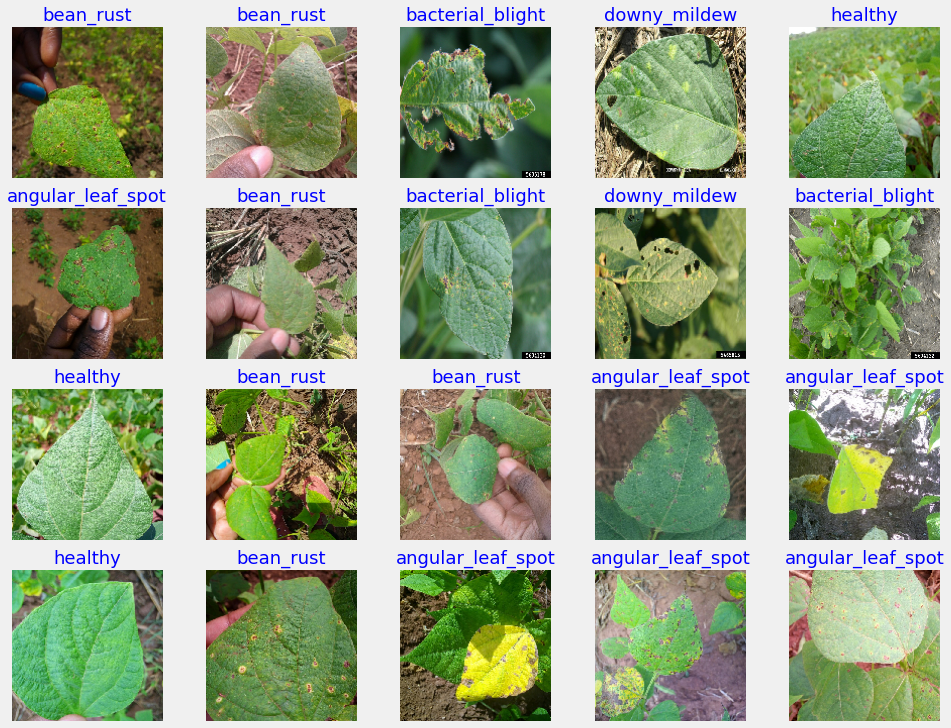

In [ ]:
showImageSamples(trainGen)

In [ ]:
modelV2 = createModelV2((150,150))
history = predictor(modelV2,'modelV2.h5',vb=0)


Epoch 1: val_categorical_accuracy improved from -inf to 0.45960, saving model to modelV2.h5

Epoch 2: val_categorical_accuracy improved from 0.45960 to 0.59756, saving model to modelV2.h5

Epoch 3: val_categorical_accuracy improved from 0.59756 to 0.70427, saving model to modelV2.h5

Epoch 4: val_categorical_accuracy improved from 0.70427 to 0.74695, saving model to modelV2.h5

Epoch 5: val_categorical_accuracy improved from 0.74695 to 0.78735, saving model to modelV2.h5

Epoch 6: val_categorical_accuracy did not improve from 0.78735

Epoch 7: val_categorical_accuracy improved from 0.78735 to 0.83155, saving model to modelV2.h5

Epoch 8: val_categorical_accuracy improved from 0.83155 to 0.86357, saving model to modelV2.h5

Epoch 9: val_categorical_accuracy did not improve from 0.86357

Epoch 10: val_categorical_accuracy improved from 0.86357 to 0.87805, saving model to modelV2.h5

Epoch 11: val_categorical_accuracy improved from 0.87805 to 0.93064, saving model to modelV2.h5

Epoch 12

## **Results and Confusion Matrics**

42/42 [==============================] - 8s 195ms/step


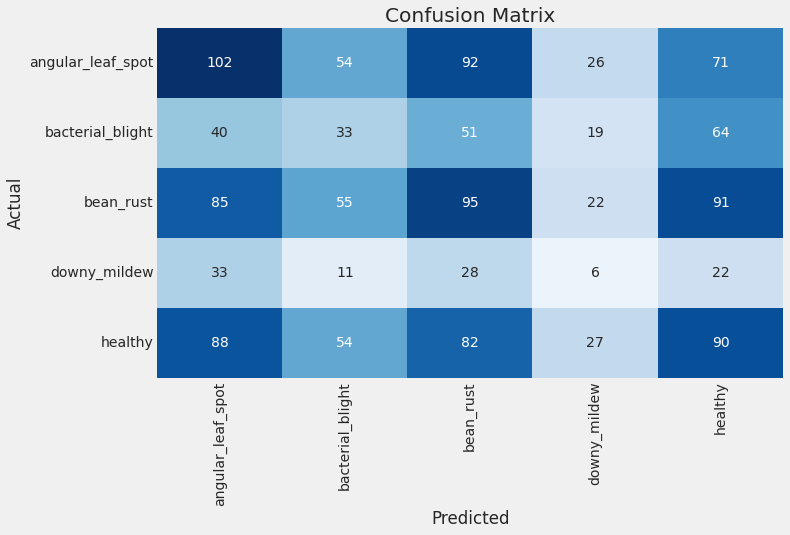

Classification Report:
----------------------
                    precision    recall  f1-score   support

angular_leaf_spot     0.2931    0.2957    0.2944       345
 bacterial_blight     0.1594    0.1594    0.1594       207
        bean_rust     0.2730    0.2730    0.2730       348
     downy_mildew     0.0600    0.0600    0.0600       100
          healthy     0.2663    0.2639    0.2651       341

         accuracy                         0.2431      1341
        macro avg     0.2104    0.2104    0.2104      1341
     weighted avg     0.2430    0.2431    0.2431      1341



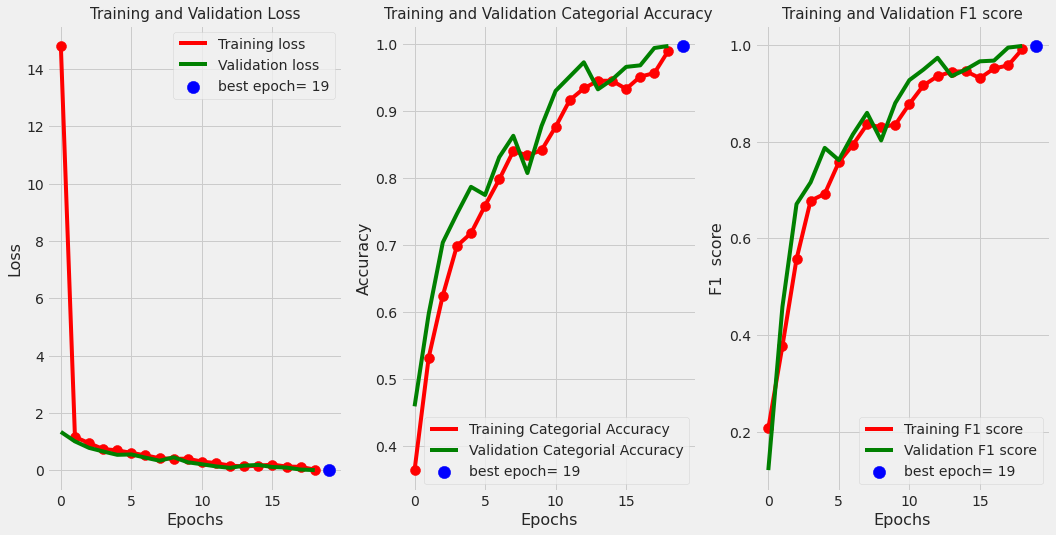

Overall Test Accuracy 24.31
Overall F1 Score 24.31


In [ ]:
acc,f1score=generateCheckReport(modelV2,testGen)
plotFunc(history.history)
print("Overall Test Accuracy {0:.2f}".format(acc))
print("Overall F1 Score {0:.2f}".format(f1score))

# **Training CNN Model with Augmented Dataframe**

In [ ]:
workingDir = '/tmp/Data'

if os.path.exists(workingDir):
  shutil.rmtree(workingDir)
trainDf, testDf, validDf, classes, classCount=makeDataframes('./soyabean-disease-dataset/train/train/','./soyabean-disease-dataset/test/test/', './soyabean-disease-dataset/validation/validation/', None)
trainDf, imgSize, classes, classCount= augmentDataset(trainDf,(150,150), 300, 0, workingDir)
trainGen, testGen, validGen= makeGens(32, trainDf, testDf, validDf, imgSize)

number of classes in processed dataset=  5
the maximum files in any class in trainDf is  348   the minimum files in any class in trainDf is  100
trainDf length:  1341   testDf length:  143   validDf length:  170
dataframe initially is of length  1341  with  5  classes
after trimming, the maximum samples in any class is now  300  and the minimum samples in any class is  0
the trimmed dataframe now is of length  1207  with  5  classes
Initial length of dataframe is  1207
Length of augmented dataframe is now  1500
Found 1500 validated image filenames belonging to 5 classes.
Found 168 validated image filenames belonging to 5 classes.
Found 143 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Below are some example training images


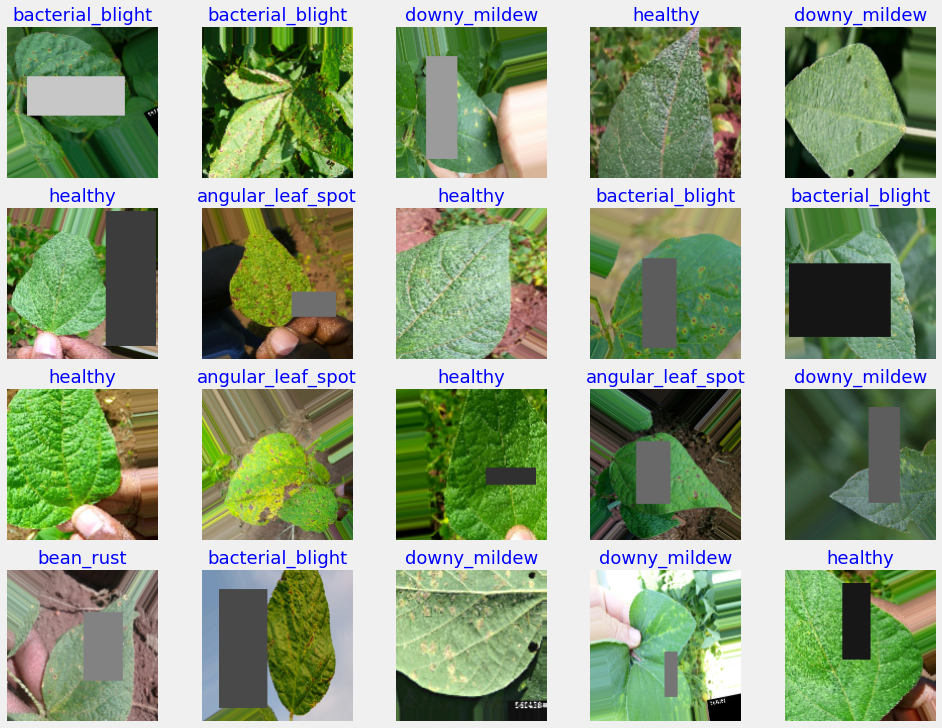

In [ ]:
showImageSamples(trainGen)

In [ ]:
modelV2_1 = createModelV2((150,150))
history = predictor(modelV2_1,'modelV2_1.h5',vb=0)


Epoch 1: val_categorical_accuracy improved from -inf to 0.39375, saving model to modelV2_1.h5

Epoch 2: val_categorical_accuracy did not improve from 0.39375

Epoch 3: val_categorical_accuracy improved from 0.39375 to 0.48125, saving model to modelV2_1.h5

Epoch 4: val_categorical_accuracy did not improve from 0.48125

Epoch 5: val_categorical_accuracy improved from 0.48125 to 0.48750, saving model to modelV2_1.h5

Epoch 6: val_categorical_accuracy improved from 0.48750 to 0.53125, saving model to modelV2_1.h5

Epoch 7: val_categorical_accuracy did not improve from 0.53125

Epoch 8: val_categorical_accuracy improved from 0.53125 to 0.61250, saving model to modelV2_1.h5

Epoch 9: val_categorical_accuracy did not improve from 0.61250

Epoch 10: val_categorical_accuracy did not improve from 0.61250

Epoch 11: val_categorical_accuracy did not improve from 0.61250

Epoch 12: val_categorical_accuracy did not improve from 0.61250

Epoch 13: val_categorical_accuracy did not improve from 0.612

## **Results and Confusion Matrics**

11/11 [==============================] - 1s 70ms/step


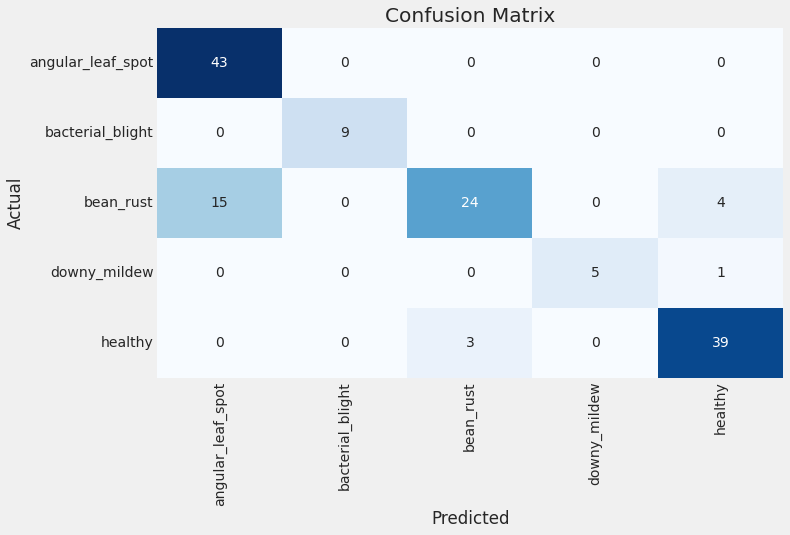

Classification Report:
----------------------
                    precision    recall  f1-score   support

angular_leaf_spot     0.7414    1.0000    0.8515        43
 bacterial_blight     1.0000    1.0000    1.0000         9
        bean_rust     0.8889    0.5581    0.6857        43
     downy_mildew     1.0000    0.8333    0.9091         6
          healthy     0.8864    0.9286    0.9070        42

         accuracy                         0.8392       143
        macro avg     0.9033    0.8640    0.8707       143
     weighted avg     0.8554    0.8392    0.8297       143



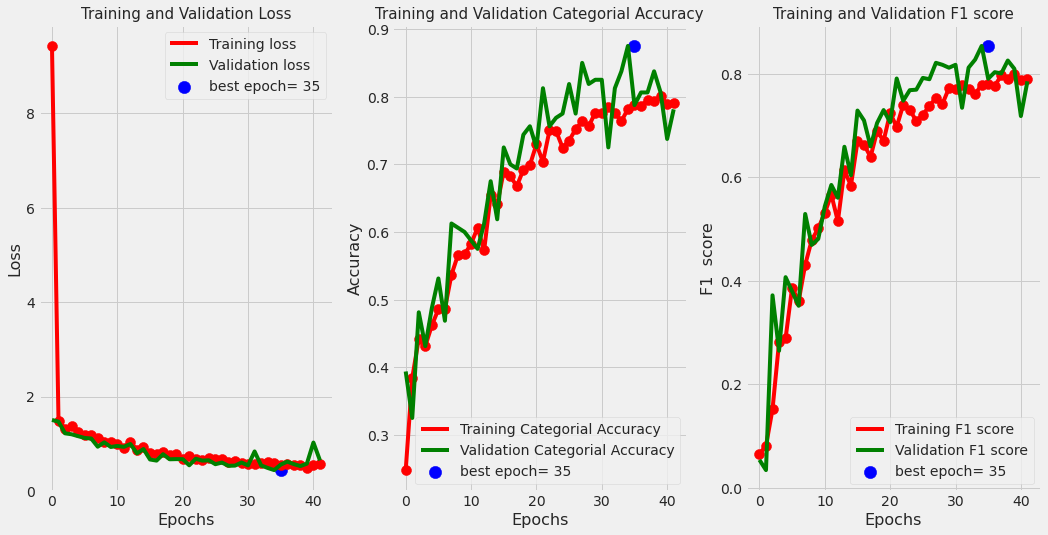

Overall Test Accuracy 83.92
Overall F1 Score 82.97


In [ ]:
acc,f1score=generateCheckReport(modelV2_1,testGen)
plotFunc(history.history)
print("Overall Test Accuracy {0:.2f}".format(acc))
print("Overall F1 Score {0:.2f}".format(f1score))

# **Training ResNetV2 Model with Augmented Dataframe**

In [ ]:
workingDir = '/tmp/Data'

if os.path.exists(workingDir):
  shutil.rmtree(workingDir)
trainDf, testDf, validDf, classes, classCount=makeDataframes('./soyabean-disease-dataset/train/train/','./soyabean-disease-dataset/test/test/', './soyabean-disease-dataset/validation/validation/', None)
trainDf, imgSize, classes, classCount= augmentDataset(trainDf,(150,150), 300, 0, workingDir)
trainGen, testGen, validGen= makeGens(32, trainDf, testDf, validDf, imgSize)

number of classes in processed dataset=  5
the maximum files in any class in trainDf is  348   the minimum files in any class in trainDf is  100
trainDf length:  1341   testDf length:  143   validDf length:  170
dataframe initially is of length  1341  with  5  classes
after trimming, the maximum samples in any class is now  300  and the minimum samples in any class is  0
the trimmed dataframe now is of length  1207  with  5  classes
Initial length of dataframe is  1207
Length of augmented dataframe is now  1500
Found 1500 validated image filenames belonging to 5 classes.
Found 168 validated image filenames belonging to 5 classes.
Found 143 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Below are some example training images


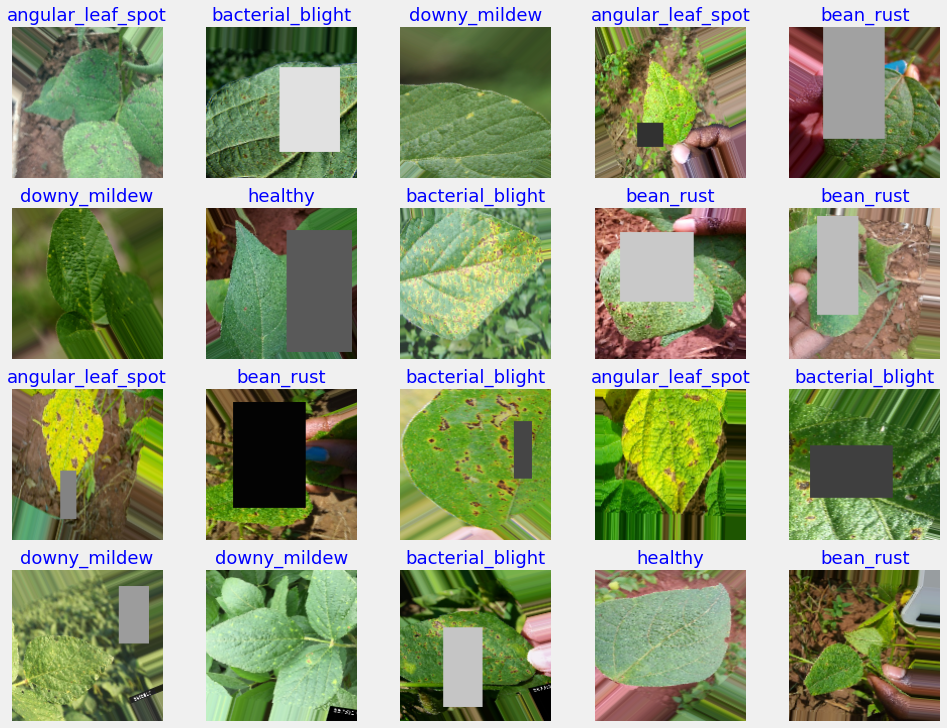

In [ ]:
showImageSamples(trainGen)

In [ ]:
modelV3 = createModelResNet(ResnetModel, lastOutput)
history = predictor(modelV3,'modelV3.h5',vb=0)

Epoch 1/50
46/46 [==============================] - ETA: 0s - loss: 1.0311 - F1_score: 0.0026 - categorical_accuracy: 0.2337 - precision: 0.2857
Epoch 1: val_categorical_accuracy improved from -inf to 0.32500, saving model to modelV3.h5
46/46 [==============================] - 39s 551ms/step - loss: 1.0311 - F1_score: 0.0026 - categorical_accuracy: 0.2337 - precision: 0.2857 - val_loss: 1.0290 - val_F1_score: 0.0444 - val_categorical_accuracy: 0.3250 - val_precision: 0.3077
Epoch 2/50
46/46 [==============================] - ETA: 0s - loss: 1.0148 - F1_score: 0.0053 - categorical_accuracy: 0.3168 - precision: 0.3636
Epoch 2: val_categorical_accuracy improved from 0.32500 to 0.42500, saving model to modelV3.h5
46/46 [==============================] - 22s 485ms/step - loss: 1.0148 - F1_score: 0.0053 - categorical_accuracy: 0.3168 - precision: 0.3636 - val_loss: 1.0903 - val_F1_score: 0.0309 - val_categorical_accuracy: 0.4250 - val_precision: 0.1429
Epoch 3/50
46/46 [=====================

## **Results and Confusion Matrics**

11/11 [==============================] - 3s 278ms/step


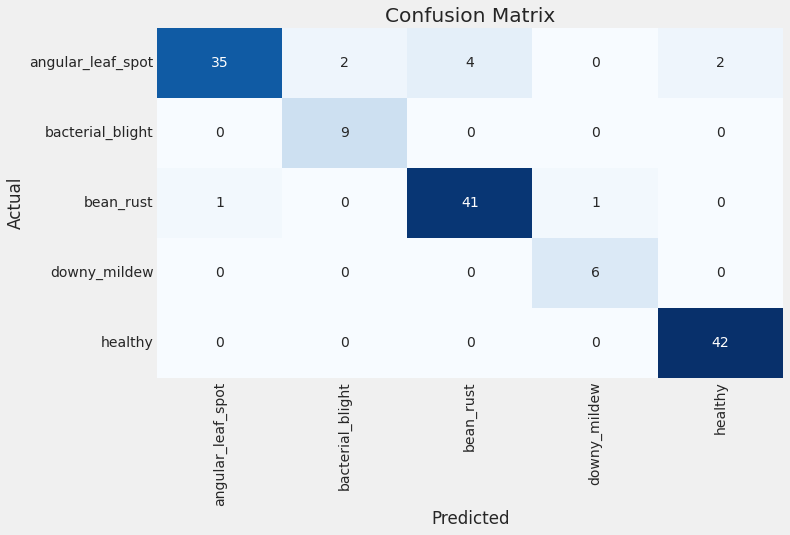

Classification Report:
----------------------
                    precision    recall  f1-score   support

angular_leaf_spot     0.9722    0.8140    0.8861        43
 bacterial_blight     0.8182    1.0000    0.9000         9
        bean_rust     0.9111    0.9535    0.9318        43
     downy_mildew     0.8571    1.0000    0.9231         6
          healthy     0.9545    1.0000    0.9767        42

         accuracy                         0.9301       143
        macro avg     0.9026    0.9535    0.9235       143
     weighted avg     0.9341    0.9301    0.9289       143



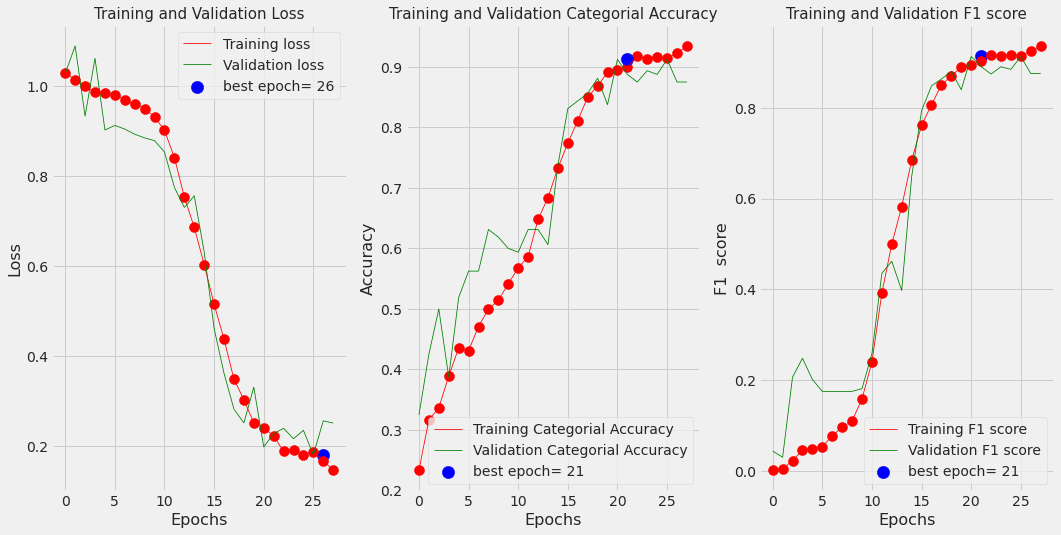

Overall Test Accuracy 93.01
Overall F1 Score 92.89


In [ ]:
acc,f1score=generateCheckReport(modelV3,testGen)
plotFunc(history.history)
print("Overall Test Accuracy {0:.2f}".format(acc))
print("Overall F1 Score {0:.2f}".format(f1score))